## 参考文献汇总
- Reference 1: Kaggle Kernel [Code sharing, 13th place, no external data](https://www.kaggle.com/c/rossmann-store-sales/discussion/17979)
- Reference 2: Kaggle Kernel-[A Journey through Rossmann Stores](https://www.kaggle.com/omarelgabry/rossmann-store-sales/a-journey-through-rossmann-stores)
- Reference 3: Kaggle Kernel-[Predict_sales_with_pandas](https://www.kaggle.com/zygmunt/rossmann-store-sales/predict-sales-with-pandas-py)
- Reference 4:[XGBoost:Notes on Parameter Tuning](http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html)
- Reference 5:[XGBoost Parameters](http://xgboost.readthedocs.io/en/latest/parameter.html)
- Reference 6:[Complete Guide to Parameter Tuning in XGBoost (with codes in Python)](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- Reference 7:[XGBoost Feature Importance](https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2)


## 文档使用说明
1. 运行程序前，从[Kaggle](https://www.kaggle.com/c/rossmann-store-sales/data)官网下载数据store.csv.zip、train.csv.zip和test.csv.zip，将解压后的store.csv、train.csv、test.csv放在与本文档同目录下的data文件夹中
2. section 0为准备工作，每次运行该程序都需要执行
3. section 1会生成后续数据可视化、模型训练所需要的数据，运行一次后将会在该程序同目录下生成文件
4. section 2为数据可视化，在section 1运行成功后，可以只运行section 0和2来完成；
5. section 3为生成基准模型，在section 1运行成功后，可以只运行section 0和3来完成；
6. section 4/5为生成基准模型，在section 1运行成功后，可以只运行section 0和4/5来完成；


## 准备工作
### 0.1 调入库函数

- 1. build model 
- 2. 确定model随机的seed
- 3. 优化模型- 可以优化的超参数：
    - Embedding空间
    - 模型结构及大小

In [29]:
#基本计算类
import pandas as pd
import numpy as np
from pandas import Series,DataFrame

#可视化
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display 

#xgboost库函数
import xgboost as xgb


#tensorflow,keras 库
import tensorflow as tf
import keras
from keras.models import  *
from keras.layers import  *

#时间类
import time
import datetime
from isoweek import Week

#文件类
import os
import pickle

#其他
import itertools
import operator


#基本设定

%matplotlib inline
sns.set_style('whitegrid')

### 0.2 定义评估指标
本项目采用Kaggle比赛的评估指标：RMSPE（误差百分比的均方差），可表示为
$$
RMSPE= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\frac{y_i-\hat{y_i}}{y_i})^2}
$$
其中，任何当天销售额为0的数据在评估时将被忽略； $y_i$ 表示某药店在某天的实际销售额，而$\hat{y_i}$ 表示该药店在对应这一天的预测销售额。

### 0.3 Setting seed

In [2]:
seed_1=42

## 1. 构建Embedding初始模型，并预测结果


###  1.0数据读入及预处理
#### 1.0.1 将处理好的数据从本地硬盘读入

In [3]:
file_train_store_raw_df='train_store_raw_df.pickle'
file_test_store_raw_df='test_store_raw_df.pickle'

file_feature='feature_x_list.pickle'
file_train_raw_df='train_raw_df.pickle'
file_store_raw_df='store_raw_df.pickle'
path='data_inter_transfer'

train_raw_df=pd.read_pickle(os.path.join(path, file_train_raw_df))

store_raw_df=pd.read_pickle(os.path.join(path, file_store_raw_df))

train_store_raw_df=pd.read_pickle(os.path.join(path, file_train_store_raw_df))

test_store_raw_df=pd.read_pickle(os.path.join(path, file_test_store_raw_df))


feature_x_list=pd.read_pickle(os.path.join(path, file_feature)).tolist()

#### 1.0.2 每个特征所对应的unique数值
- dict_feature_range：每个feature所对应的范围
- dict_feature_offset：每个feature最小值移到0所对应的offset

In [4]:
dict_feature_range={}
dict_feature_offset={}

for ii in feature_x_list:
    unique_list=train_store_raw_df[ii].unique()
    max_v=max(unique_list)
    min_v=min(unique_list)
    dict_feature_range[ii]=(int)(max_v-min_v+1)
    dict_feature_offset[ii]=(int)(min_v)
    print '{0: <30}'.format(ii),':','unique=','{0: <5}'.format(len(unique_list)),\
    ',max=','{0: <5}'.format((max_v)),',min=','{0: <5}'.format((min_v)), \
    ',range=','{0: <5}'.format((dict_feature_range[ii])),',offset=','{0: <5}'.format((dict_feature_offset[ii]))


Store                          : unique= 1115  ,max= 1115  ,min= 1     ,range= 1115  ,offset= 1    
DayOfWeek                      : unique= 7     ,max= 7     ,min= 1     ,range= 7     ,offset= 1    
Year                           : unique= 3     ,max= 2015  ,min= 2013  ,range= 3     ,offset= 2013 
Month                          : unique= 12    ,max= 12    ,min= 1     ,range= 12    ,offset= 1    
Day                            : unique= 31    ,max= 31    ,min= 1     ,range= 31    ,offset= 1    
DayOfYear                      : unique= 365   ,max= 365   ,min= 1     ,range= 365   ,offset= 1    
StoreType_cat                  : unique= 4     ,max= 3     ,min= 0     ,range= 4     ,offset= 0    
Assortment_cat                 : unique= 3     ,max= 2     ,min= 0     ,range= 3     ,offset= 0    
StateHoliday_cat               : unique= 4     ,max= 3     ,min= 0     ,range= 4     ,offset= 0    
SchoolHoliday                  : unique= 2     ,max= 1     ,min= 0     ,range= 2     ,offset= 0    


#### 1.0.3 将数据对应feature_x_list每列添加offset，将数据的最小值设为0

In [5]:
modified_train_store_raw_df=train_store_raw_df.copy()
modified_test_store_raw_df=test_store_raw_df.copy()

for col in feature_x_list:
    modified_train_store_raw_df[col]=modified_train_store_raw_df[col]-dict_feature_offset[col]
    modified_test_store_raw_df[col]=modified_test_store_raw_df[col]-dict_feature_offset[col]
    
for ii in feature_x_list:
    unique_list=modified_train_store_raw_df[ii].unique()
    max_v=max(unique_list)
    min_v=min(unique_list)
    print '{0: <30}'.format(ii),':','unique=','{0: <5}'.format(len(unique_list)),\
    ',max=','{0: <5}'.format((max_v)),',min=','{0: <5}'.format((min_v)), \
    ',range=','{0: <5}'.format((int)(max_v-min_v+1)),',offset=','{0: <5}'.format((int)(min_v))    

Store                          : unique= 1115  ,max= 1114  ,min= 0     ,range= 1115  ,offset= 0    
DayOfWeek                      : unique= 7     ,max= 6     ,min= 0     ,range= 7     ,offset= 0    
Year                           : unique= 3     ,max= 2     ,min= 0     ,range= 3     ,offset= 0    
Month                          : unique= 12    ,max= 11    ,min= 0     ,range= 12    ,offset= 0    
Day                            : unique= 31    ,max= 30    ,min= 0     ,range= 31    ,offset= 0    
DayOfYear                      : unique= 365   ,max= 364   ,min= 0     ,range= 365   ,offset= 0    
StoreType_cat                  : unique= 4     ,max= 3     ,min= 0     ,range= 4     ,offset= 0    
Assortment_cat                 : unique= 3     ,max= 2     ,min= 0     ,range= 3     ,offset= 0    
StateHoliday_cat               : unique= 4     ,max= 3     ,min= 0     ,range= 4     ,offset= 0    
SchoolHoliday                  : unique= 2     ,max= 1     ,min= 0     ,range= 2     ,offset= 0    


#### 1.0.4 构造train_df数据，valid_df数据,df_test数据

In [6]:
startValidDate='2015-06-15'

mask_train=(modified_train_store_raw_df['Date']<startValidDate) &(modified_train_store_raw_df['Outlier_3']==False) \
            & (modified_train_store_raw_df['Open']==1) & (modified_train_store_raw_df['Sales']>0)
mask_valid=(modified_train_store_raw_df['Date']>=startValidDate)\
            & (modified_train_store_raw_df['Open']==1)\
            & (modified_train_store_raw_df['Sales']>0)

        
df_train=modified_train_store_raw_df.loc[mask_train,feature_x_list]
df_valid=modified_train_store_raw_df.loc[mask_valid,feature_x_list]

df_test=modified_test_store_raw_df.loc[modified_test_store_raw_df['Open']==1]

#### 1.0.5 验证valid数据中每个feature是否有不包含在train数据中的unique数值

In [7]:
mask_test=(modified_test_store_raw_df['Open']==1)

for ii in feature_x_list:
    set_unique_train=set(df_train[ii].unique())
    set_unique_valid=set(df_valid[ii].unique())
    set_unique_test=set((modified_test_store_raw_df[mask_test][ii]).unique())

    
    if set_unique_train.issuperset(set_unique_valid) &(set_unique_train.issuperset(set_unique_test) ):
        print '{0: <30}'.format(ii),'= 1'
    else:
        print '{0: <30}'.format(ii),'= 0'

Store                          = 1
DayOfWeek                      = 1
Year                           = 1
Month                          = 1
Day                            = 1
DayOfYear                      = 1
StoreType_cat                  = 1
Assortment_cat                 = 1
StateHoliday_cat               = 1
SchoolHoliday                  = 1
Promo                          = 1
Promo2                         = 1
InPromo2Today                  = 1
DaysCountSinceCompetition_log  = 1
InCompetition                  = 1
InCompetitionToday             = 1
CompetitionDistance_log        = 1
DaysCountSincePromo2_log       = 1


### 1.0.6 构造embedding模型所需要的train, valid数据

In [8]:
x_train_data=[]
x_valid_data=[]
for ii in feature_x_list:
    x_train_data.append(np.array(df_train[ii]))
    x_valid_data.append(np.array(df_valid[ii]))  
y_train_data=np.array(modified_train_store_raw_df.loc[mask_train,'Sales'])
y_valid_data=np.array(modified_train_store_raw_df.loc[mask_valid,'Sales'])

### 1.1 搭建深度学习的embedding模型


In [25]:
# 计算Embedding空间
def calc_embedding_space(x):
    if x <10:
        return x
    elif x<100:
        return 10+(int)((x-10)/5)
    elif x<1000:
        return 28+(int)((x-100)/25)
    else:
        return 64+(int)((x-1000)/125)
max_log_y=np.max(np.log(y_train_data))

def _val_for_fit(val):
    val=np.log(val)
    return val/max_log_y

def _val_for_pred(val):
    return tf.exp(val*max_log_y)        

def calc_predict_rmspe(trained_model,x_data,y_data):
    predicted_value=trained_model.predict( x_data).flatten()
    return np.sqrt(np.mean(np.power((np.exp(predicted_value*max_log_y)-y_data.astype(np.float32))/y_data.astype(np.float32),2.0)))    

def loss_func_rmspe(y_true,y_pred):
    return tf.sqrt(tf.reduce_mean(tf.pow((_val_for_pred(y_pred)-_val_for_pred(y_true))/_val_for_pred(y_true),2.0)))

In [26]:
def create_embedding_model(feature_list,dropout_rate=0.2):
    models=[]
    for ii in feature_list:
        input_range=dict_feature_range[ii]
        embedding_space=calc_embedding_space(input_range)        

        model=Sequential()
        model.add(Embedding(input_range,embedding_space,input_length=1,name=ii))
        model.add(Reshape((embedding_space,), name='reshape_'+ii,input_shape=(1,embedding_space)))
        models.append(model)
    

    embedding_model=Sequential()
    embedding_model.add(Merge(models,mode='concat',concat_axis=-1,name='Merge'))


    embedding_model.add(Dense(512,kernel_initializer='uniform',activation='relu',name='Dense_1'))
    embedding_model.add(Dense(128,kernel_initializer='uniform',activation='relu',name='Dense_2'))
    embedding_model.add(Dense(32,kernel_initializer='uniform',activation='relu',name='Dense_3'))
    embedding_model.add(Dropout(dropout_rate,name='drop_out'))
    embedding_model.add(Dense(1,activation='sigmoid',name='Score'))
    embedding_model.compile(loss=loss_func_rmspe,optimizer='adam')
    return embedding_model

### 1.2 可视化网络模型

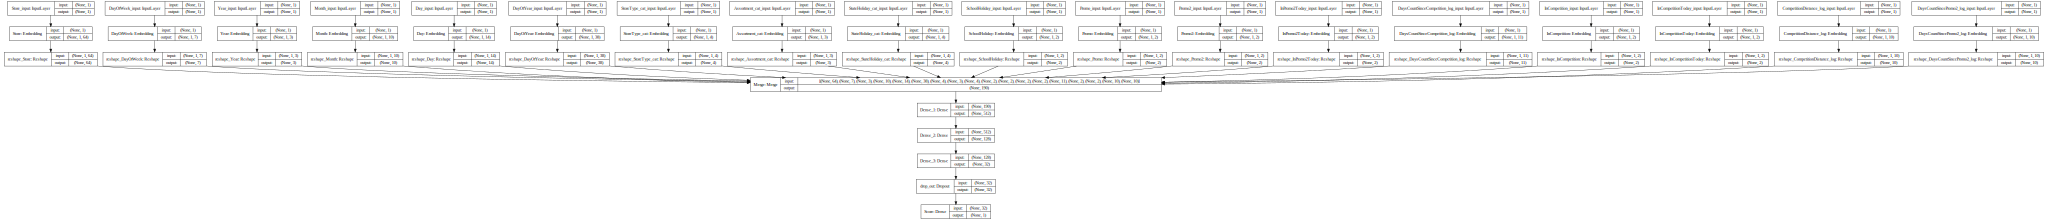

In [30]:
#from keras.utils.visualize_util import plot, model_to_dot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
# TODO: 可视化你的模型
SVG(model_to_dot(create_embedding_model(feature_x_list),show_shapes=True).create(prog='dot', format='svg'))

### 1.3 训练模型

- 可视化train_loss和valid_loss: [参考资料:Display Deep Learning Model Training History in Keras](http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)
- [EarlyStopping 参考资料](http://stackoverflow.com/questions/37293642/how-to-tell-keras-stop-training-based-on-loss-value)
- 保存中间模型[参考资料How to Check-Point Deep Learning Models in Keras](http://machinelearningmastery.com/check-point-deep-learning-models-keras/)

In [35]:
from keras.callbacks import  EarlyStopping,ModelCheckpoint
embedding_model=create_embedding_model(feature_x_list,dropout_rate=0.01)


path='model_saved/embedding_model'
filepath="weights-improvement-{epoch:02d}-{val_loss:.5f}.hdf5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=0),
    ModelCheckpoint(os.path.join(path,filepath), monitor='val_loss', save_best_only=False, verbose=0)]

history=embedding_model.fit(x_train_data, _val_for_fit(y_train_data), 
                    validation_data=(x_valid_data,_val_for_fit(y_valid_data)),
                    epochs=50, 
                    batch_size=128,
                    callbacks=callbacks
                )

Train on 786180 samples, validate on 45852 samples
Epoch 1/50
786180/786180 [==============================] - 55s - loss: 0.1531 - val_loss: 0.1454
Epoch 2/50
786180/786180 [==============================] - 53s - loss: 0.1145 - val_loss: 0.1363
Epoch 3/50
786180/786180 [==============================] - 54s - loss: 0.1028 - val_loss: 0.1378
Epoch 4/50
786180/786180 [==============================] - 54s - loss: 0.0948 - val_loss: 0.1377
Epoch 5/50
786180/786180 [==============================] - 54s - loss: 0.0904 - val_loss: 0.1391
Epoch 6/50
786180/786180 [==============================] - 54s - loss: 0.0869 - val_loss: 0.1340
Epoch 7/50
786180/786180 [==============================] - 57s - loss: 0.0842 - val_loss: 0.1415
Epoch 8/50
786180/786180 [==============================] - 57s - loss: 0.0830 - val_loss: 0.1485
Epoch 9/50
786180/786180 [==============================] - 58s - loss: 0.0813 - val_loss: 0.1342
Epoch 10/50
786180/786180 [==============================] - 60s - 

In [36]:
valid_rmspe=calc_predict_rmspe(embedding_model,x_valid_data,y_valid_data)
train_rmspe=calc_predict_rmspe(embedding_model,x_train_data,y_train_data)
print "train_rmspe :{:f},\tvalid_rmspe:{:f}".format(train_rmspe,valid_rmspe)

train_rmspe :0.062844,	valid_rmspe:0.136739
